# <span style="color:orange"> Exercise 8 </span>
## <span style="color:green"> Task </span>
Use datablocking to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

with
$$
V(x) = x^4 - \frac{5}{2}x^2
$$
and
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

Then, use your Variational Monte Carlo code to find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$:

$$
\langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

## <span style="color:green"> Solution </span>
The exercise is made up of a ```main.cpp``` file, a ```metropolis.hpp``` file that implements the algorithm to simulate the quantum particle, and other libraries like the datablocking method, the pseudo-random number generator and the container for the definitions of wavefunctions.<br>
The main program reads the parameters $\mu$ and $\sigma$ from command-line, together with a boolean parameter that dictates whether the simulation has been called by an automated (Python) script, or if it has been called manually.
Then, thanks to an equilibration phase, the program seeks an optimal value for the parameter $\delta$, which is the size of the interval centered in the current particle position where the new proposed position is uniformly sampled from. In fact, a new position for the quantum particle is generated according to $u\in U([0,1])$. This equilibration phase adjusts the delta parameter by an addend $\pm\frac{1}{i+1}$, where $i$ is the equilibration iteration, until a desired value of acceptance is found, typically 50\%. This is better than hard-coding a value for $\delta$, because in case the latter is too small, it may take too long for the Metropolis algorithm to converge to the expected value, since more proposed positions are discarded. On the other hand, if the $\delta$ value is too large, an inaccurate solution might be converged on too quickly.<br>
Finally, the simulation is run and the energy is calculated from the wavefunction, and the results are saved to a file after the datablocking method. A python script ```run.py``` was written to automate the execution of numerous simulation while questing for the optimal parameters of $\mu$ and $\sigma$, that have been explored in the ranges $[0.6, 1.0]$ and $[0.4, 0.8]$ respectively.

In [46]:
import numpy as np
import configparser
import utils
import re
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
mypath = "./outputs/"

Here, the expectation value for the hamiltonian is computed for the values $\mu=1$ and $\sigma=1$. On the graph, I plotted the energy obtained from datablocking together with the value of the final block to be compared with the expectation value of the energy of ground state. The parameters respectively represent the width and distance from the origin of the sum of two gaussians that try to represent the energy of ground state of the double-well potential. It is then obvious that these values for $\mu$ and $\sigma$ do not reconstruct the ground state really well, and an optimization search must be done to find the optimal parameters.

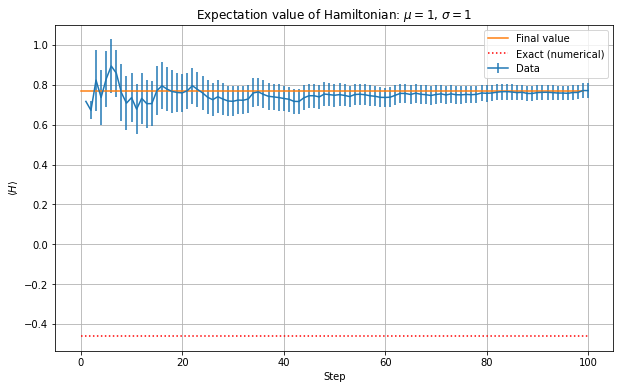

In [69]:
i, ene, err = np.loadtxt("./8.2/outputs/single/1/energy.dat",unpack=True)
fig, ax = plt.subplots(figsize=(10,6))
plt.errorbar(i,ene,yerr=err,label="Data")
plt.plot([ene[-1] for i in range(len(i))],label="Final value")
plt.hlines(
    -0.46046,
    0,
    i[-1],
    colors = "red",
    linestyle = "dotted",
    label = "Exact (numerical)"
)
plt.xlabel("Step")
plt.ylabel(r"$\langle H \rangle$")
plt.title(r"Expectation value of Hamiltonian: $\mu=1$, $\sigma=1$")
plt.grid(True)
plt.legend()
plt.show()

The following plot shows the expectation value of the Hamiltonian for $\mu=1$ and $\sigma=1$ as a function of the initial position of the quantum 1D particle. As shown, the 

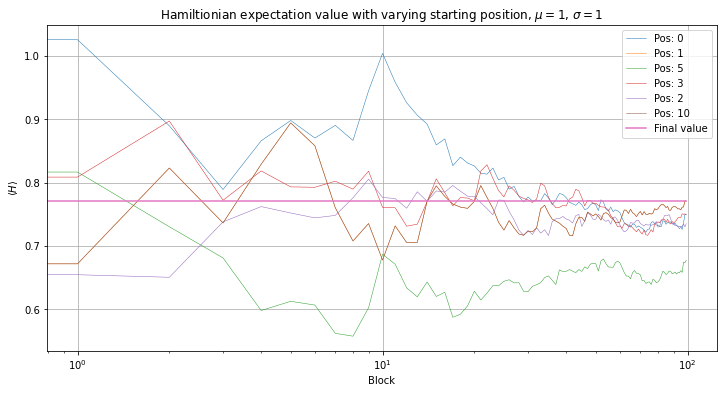

In [70]:
fig, ax = plt.subplots(figsize=(12,6))
for dir in listdir("./8.2/outputs/single/"):
    lines = open(f"./8.2/outputs/single/{dir}/settings.txt").read().split("\n")
    results = zip(lines[0].split("\t"), lines[1].split("\t"))
    i, en, err = np.loadtxt(f"./8.2/outputs/single/{dir}/energy.dat", unpack=True)
    plt.plot(en,label=f"Pos: {list(results)[2][1]}",linewidth=0.5)
plt.plot([ene[-1] for i in range(len(i))], label="Final value")
plt.xlabel("Block")
plt.ylabel(r"$\langle H \rangle$")
plt.xscale("log")
plt.title("Hamiltionian expectation value with varying starting position, $\mu=1$, $\sigma=1$")
plt.grid(True)
plt.legend()
plt.show()

Below, a 2D grid shows the expectation value of the Hamiltonian as a function of the parameters $\mu$ and $\sigma$. The legend hints that the darker the color, the closer the estimated value is to the real value of -0.46046. It can be seen that the minimum is found for values $\mu\approx0.8$ and $\sigma\approx0.6$

Data shape:  (40, 40)
0.60 1.00 0.40 0.80


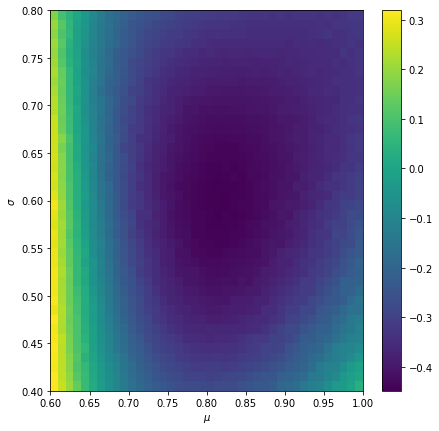

In [71]:
import math
dir = "./8.2/outputs/automation/energies/"
size = int(math.sqrt(len(listdir(dir))))
data = np.zeros((size,size), dtype="float")
print("Data shape: ",data.shape)
fig, axes = plt.subplots(figsize=(7,7))

for index, file in enumerate(sorted(listdir(dir))):
    temp = re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+", file)
    if index==0:
        mu_min = temp[0]
        sigma_min = temp[1]
    if index==len(listdir(dir))-1:
        mu_max = temp[0]
        sigma_max = temp[1]
    i, ene, err = np.loadtxt(dir+file, unpack=True)
    #print(file,"   ",ene[-1])
    data[int(index/size)][index%size] = ene[-1]
print(mu_min, mu_max, sigma_min, sigma_max)
im = plt.imshow(data, interpolation="nearest",  extent = (float(mu_min), float(1), float(sigma_min), float(sigma_max)))
axes.set_xlabel(r"$\mu$")
axes.set_ylabel(r"$\sigma$")
axes.set_aspect("auto")
fig.colorbar(im)
plt.show()

I decided to plot the following graphs to show the behaviour of the 1D quantum particle position with different values of $\mu$ and $\sigma$, where the first row of graphs shows a variation of $\sigma$, while the second row shows a variation of $\mu$. As states earlier, the parameter $\mu$ is meant to vary the width of the two gaussians, while the parameter $\sigma$ shows the distance from the origin.

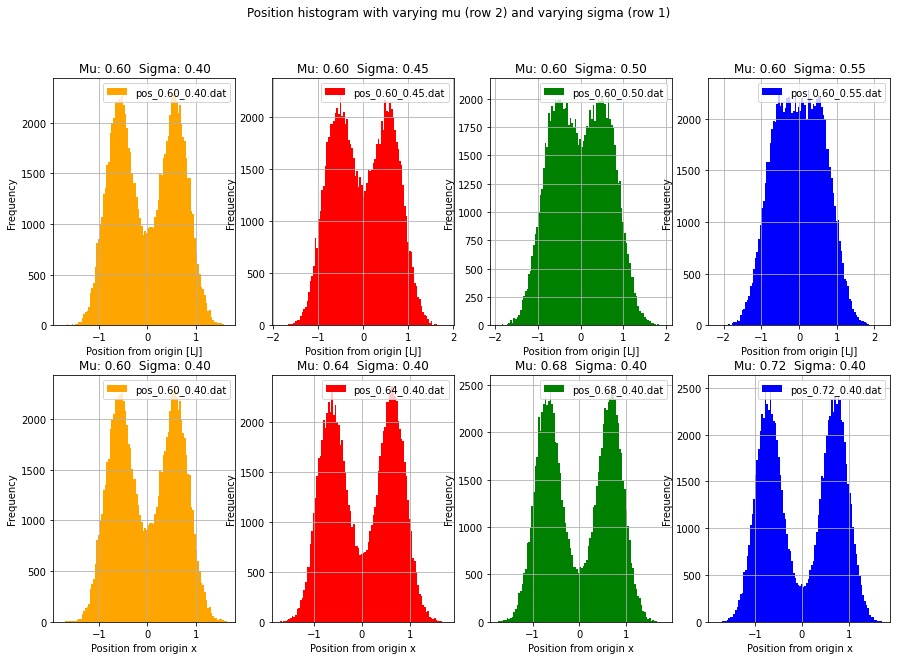

In [72]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
colors = ("orange","red","green","blue")
dir = "./8.2/outputs/automation/positions/"
plt.suptitle("Position histogram with varying mu (row 2) and varying sigma (row 1)")
for index, file in enumerate(sorted(listdir(dir))[:20:5]):
    pos = np.loadtxt(dir+file, unpack=True)
    title = re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+", file)
    ax[0][index].set_title(f"Mu: {title[0]}  Sigma: {title[1]}")
    ax[0][index].hist(pos, label=file, bins=100, color=colors[index])
    ax[0][index].set_xlabel("Position from origin [LJ]")
    ax[0][index].set_ylabel("Frequency")
    ax[0][index].grid(True)
    ax[0][index].legend()
for index, file in enumerate(sorted(listdir(dir))[:160*4:160]):
    pos = np.loadtxt(dir+file, unpack=True)
    title = re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+", file)
    ax[1][index].set_title(f"Mu: {title[0]}  Sigma: {title[1]}")
    ax[1][index].hist(pos, label=file, bins=100, color=colors[index])
    ax[1][index].set_xlabel("Position from origin x")
    ax[1][index].set_ylabel("Frequency")
    ax[1][index].grid(True)
    ax[1][index].legend()

The final graphs show the expectation value of the Hamiltonian as a function of the integration block for the optimized parameters of $\mu$ and $\sigma$. Moreover, a histogram with the positions of the quantum particle (wavefunction square modulus) is plotted against the numerical solution of ground state as well as the double-well potential.

Best parameters:
- Mu: 0.78
- Sigma: 0.61
- Ene: -0.448169




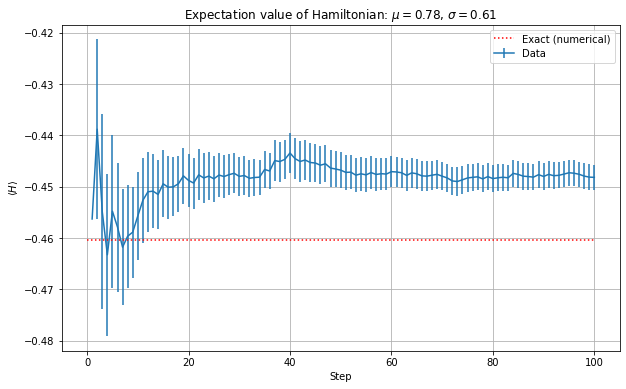

Ground state energy:  -0.46046587969271563
1st excited state energy:  0.09742471331761027
2nd excited state energy:  1.971733134393021
optimized parameters [mu,sigma,c] =
[0.73857356 0.51405166 0.3942103 ]
parameters uncertainty =
[0.0011756  0.00133421 0.00098857]


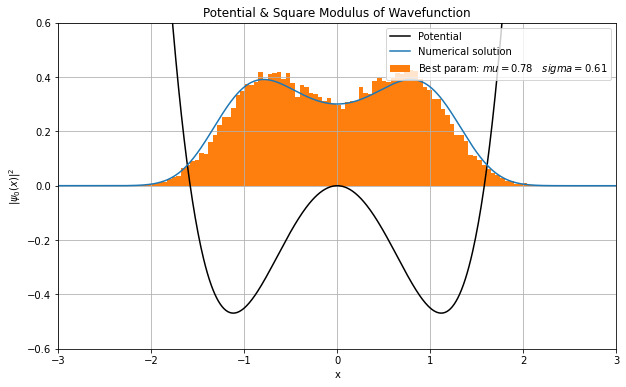

In [73]:
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import pyplot as plt

mu, sigma, ene = np.loadtxt("./8.2/outputs/automation/best.dat",unpack=True)
print(f"Best parameters:\n- Mu: {mu}\n- Sigma: {sigma}\n- Ene: {ene}\n\n")

fig, ax = plt.subplots(figsize=(10,6))
i, ene, err = np.loadtxt(f"./8.2/outputs/automation/energies/results_{mu}_{sigma}.dat",unpack=True)
plt.errorbar(i, ene, yerr=err, label="Data")
plt.grid(True)
plt.title(r"Expectation value of Hamiltonian: $\mu={mu}$, $\sigma={sigma}$".format(mu=mu, sigma=sigma))
plt.xlabel("Step")
plt.ylabel(r"$\langle H \rangle$")
plt.hlines(
    -0.46046,
    0,
    i[-1],
    colors = "red",
    linestyle = "dotted",
    label = "Exact (numerical)"
)
plt.legend()
plt.show()

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

def f(x,mu,sigma,c):
    return c*(np.exp(-(x-mu)**2/(2*sigma**2))+np.exp(-(x+mu)**2/(2*sigma**2)))

hbar = 1
m = 1
a = 10    #range in cui studio la funzine
N = 1000 # number of iterations e punti del mio spazio

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

p_opt, p_cov = curve_fit(f, x, (psi[0])**2)
y_fit = f(x,p_opt[0],p_opt[1],p_opt[2])

print("optimized parameters [mu,sigma,c] =")
print(p_opt)
print("parameters uncertainty =")
print(np.sqrt(np.diagonal(p_cov)))

y=np.loadtxt(f"./8.2/outputs/automation/positions/pos_{mu}_{sigma}.dat")
# Plots
plt.figure(figsize=(10,6))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2, label="Numerical solution")
plt.hist(y, bins=100, density=True, label=rf"Best param: $mu={mu}\quad sigma={sigma}$")


plt.title("Potential & Square Modulus of Wavefunction")
plt.xlabel("x")
plt.ylabel(r"$|\psi_0(x)|^2$")
plt.legend()
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

### PIGS/PIMC code
#### Simulation of the ground state
The folllowing plots show the results of the path-integral ground-state Monte Carlo algorithm: starting from the wavefunctions (not normalised):
$$
\psi_1(x)=1,
\hspace{1cm}
\psi_2(x)=\exp\biggl(-\frac{(x-\mu)^2}{2\sigma^2}\biggr)+\exp\biggl(-\frac{(x+\mu)^2}{2\sigma^2}\biggr),
$$
where the program calculates the shape of the probability density function of the ground state. 

The graphs for the ground state can be obtained by calling the ```qmc1d``` executable while passing ```input.pigs``` as a first parameter. For both types of Path Integral, the program takes care of initializing and creating the required output directories. In order to switch between the two projected wavefunctions, the parameter flat ($\Psi_1$) or bumps ($\Psi_2$) must be passed inside the input file.

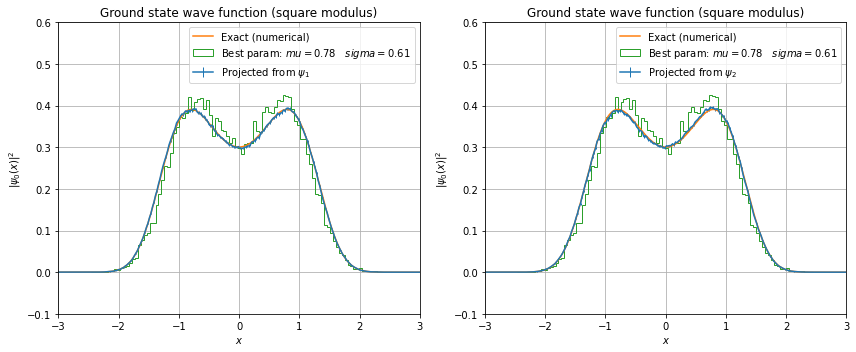

In [67]:
prefix = "8.3/outputs/PIGS/"

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

# Histogram of the square modulus of the wave function.
x_bins, h_avg, h_err = np.loadtxt(prefix + "probability_flat.dat", unpack = True)
axes[0].errorbar(
    x_bins,
    h_avg,
    yerr = h_err,
    elinewidth = 1,
    label = r"Projected from $\psi_1$"
)

x_bins, h_avg, h_err = np.loadtxt(prefix + "probability_bumps.dat", unpack = True)
axes[1].errorbar(
    x_bins,
    h_avg,
    yerr = h_err,
    elinewidth = 1,
    label = r"Projected from $\psi_2$"
)

for ax in axes:
    ax.set_title("Ground state wave function (square modulus)")
    ax.set_ylabel(r"$|\psi_0(x)|^2$")
    ax.set_xlabel(r"$x$")
    ax.plot(x, (psi[0])**2, label = "Exact (numerical)")
    ax.set_xlim((-3, 3))
    ax.set_ylim((-0.1, 0.6))
    ax.hist(y, bins=100, density=True, histtype='step' ,label=rf"Best param: $mu={mu}\quad sigma={sigma}$")
    ax.legend()
    ax.grid(True)
    
fig.tight_layout()
plt.show()

The graphs show that the results from both wavefunctions are very close to the numerical solution of the ground state, even better than the solution obtained with Variational MC methods.  

#### Simulation for positive temperatures
The following shows the results of the path-integral Monte Carlo algorithm, simulating a system at a positive temperature. The plot shows the wavefunction of the system as the temperature increases. For this purpose, a python script has been written to create a temporary input file where the temperature increases as a power of 2, and the simulation is executed with the temporary file as a command-line argument.

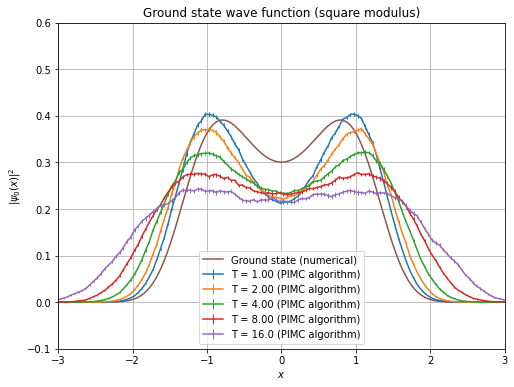

In [61]:
prefix = "./8.3/outputs/PIMC/"
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))

# Histogram of the square modulus of the wave function.
for temp in ["1.00", "2.00", "4.00", "8.00", "16.0"]: #or os.listdir()
    x_bins, h_avg, h_err = np.loadtxt(prefix + "probability_" + temp + ".dat", unpack = True)
    axes.errorbar(
        x_bins,
        h_avg,
        yerr = h_err,
        elinewidth = 1,
        label = "T = " + temp + " (PIMC algorithm)"
    )
# (The results are the same regardless of the trial wavefunction.)

axes.set_title("Ground state wave function (square modulus)")
axes.set_ylabel(r"$|\psi_0(x)|^2$")
axes.set_xlabel(r"$x$")
axes.grid(True)
axes.plot(x, (psi[0])**2, label = "Ground state (numerical)")
axes.set_xlim((-3, 3))
axes.set_ylim((-0.1, 0.6))
axes.legend()
axes.grid(True)

plt.show()

The plot shows that as the temperature is increased, the sampled wavefunction becomes broader: this is a sign that the excited states weigh more and more in the statistical ensemble.